# General Tests
There is no rhyme or reason to this file, besides helping me test the code. Its all nonessential

# Testing Predict Features

In [1]:
import test_manifold_algorithms as tma
#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "random", percent_of_anchors= [0.3], verbose = 2)

2024-06-04 16:58:13.815257: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 16:58:13.820773: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-04 16:58:13.892353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 16:58:15.734697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

Splitting the data randomly
Split A features shape: (150, 3)
Split B Features shape (150, 1)
MDS initialized with 2 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [2]:
from DIG import DIG
import numpy as np
import pandas as pd
import DIG_V2
#test = DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

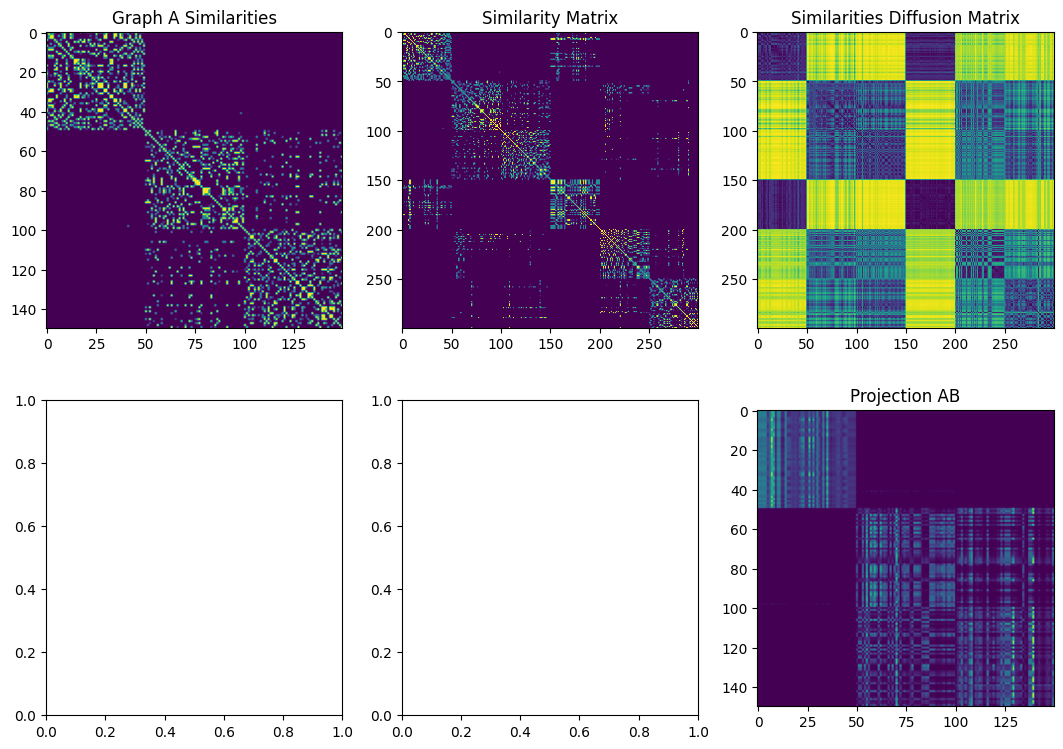

In [3]:
test.plot_graphs()

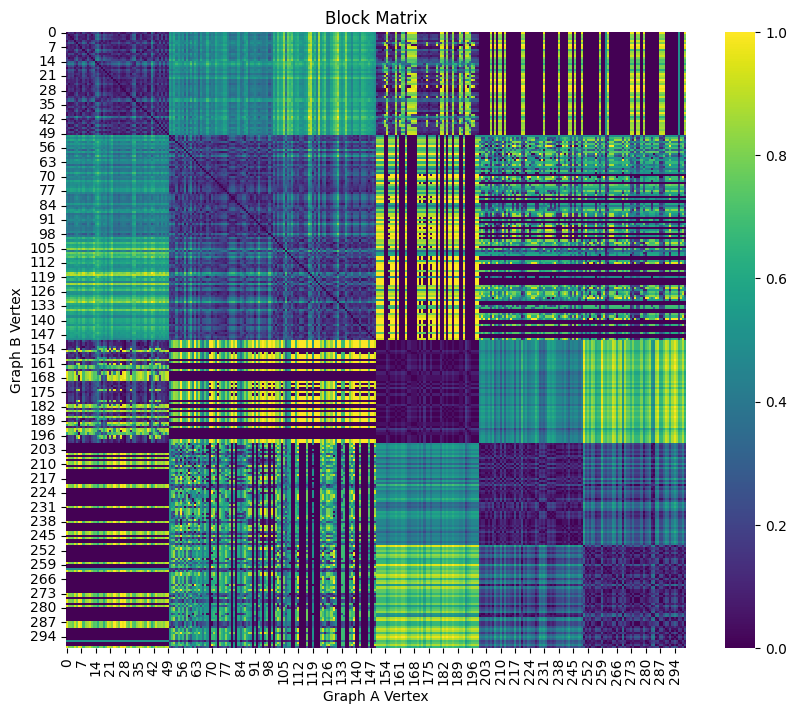

In [71]:
from SPUD import SPUD
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs", kind = "distance", show = True)

# Finding the Possible Anchor Tests

## ------------ ----------- Ideas, Questions, and the Mindless ------------ ----------- 

#### Ideas: 
1. We currently force that each point can only have one anchor (because we assume its a one to one correspondonce). However, what if we removed that limitation? Would it be better? My supporting thought for this, is if the algorithm is fairly confident that two points are anchors, they are very similar, and so the algorithm would benefit from thinking them as anchors anyways; even though we know one of the points are wrong
2. Sometimes, our hold_out_anchor scores a remarkably high distance from each other. We can maybe set a thing that if no anchors are within the threshold, we can make that hold_out_anchor actually an anchor -- my guess is that it will have the greatest effect on the alignment.

### Questions:
1. If the threshold is too high, the algorithm can take a long time (and I bet longer with bigger datasets). However, if we choose the anchor_limit to be small, it is always very fast. Would it be better to have the algorthim work on the anchor_limit first, and then check the threshold? (I think yes). Currently, this is the difference between find_possible_anchors and find_possible_anchors2


In [4]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    array = self.sim_diffusion_matrix[:test.len_A, test.len_A:]

        #Set anchor limit to all
    if anchor_limit == None:
        anchor_limit = np.min(array.shape)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.mean(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?
            #threshold += _65_percent_interval

    """ This section actually finds and then curates potential anchors """

    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")
    
    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.inf
    array[:, self.known_anchors[:, 1]] = np.inf

    hold_out_anchors =np.array(hold_out_anchors)
    array[hold_out_anchors[:, 0], :] = np.inf
    array[:, hold_out_anchors[:, 1]] = np.inf
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Filter coordinates based on the threshold
    selected_coords = [(r, c) for r, c in coordinates if array[r, c] <= threshold]
    num_elements = len(selected_coords)
    
    # Create a cost matrix using the valid elements
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*100)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Add the data
            min_pairs.append((row, col))
            used_rows.add(row)
            used_cols.add(col)

            #Break once we hit our limit
            if len(min_pairs) >= anchor_limit:
                break
    
    return min_pairs, array


In [5]:
from scipy.optimize import linear_sum_assignment
def _find_possible_anchors2(self, anchor_limit = None, threshold = "auto", hold_out_anchors = []): 
    """A helper function that finds and returns a list of possible anchors after alignment.
        
    Parameters:
        :anchor_limit: should be an integer. If set, it will cap out the max amount of anchors found.
        :threshold: should be a float. If auto, the algorithm will determine it.
            The threshold determines how similar a point has to be to another to be considered an anchor
        :hold_out_anchors: Only matters if Threshold is set to auto. These anchors are used as a test to validate the Threshold.
            They should be in the same format as the Known Anchors.
        
    returns possible anchors plus known anchors in a single list"""

    #Set our array. This lets us modify it if we need to
    array = self.sim_diffusion_matrix[:test.len_A, test.len_A:]

    #Set anchor limit to 1/3 of the unknown data points
    if anchor_limit == None:
        anchor_limit = int((np.min(array.shape) - len(self.known_anchors)) / 3)
    
    #Calculate the predicted anchor value
    if threshold == "auto":

        #Change Type so that we can convert to set 
        known_anchors_as_tuples = (tuple(arr) for arr in self.known_anchors)
        hold_out_anchors = [tuple(arr) for arr in hold_out_anchors]

        # Convert the list of tuples to a set for fast look ups
        set1 = set(known_anchors_as_tuples)

        #Remove indicies that are already known anchors
        hold_out_anchors[:] = [tup for tup in hold_out_anchors if tup not in set1]

        #Check to make sure we have Hold out anchors
        if len(hold_out_anchors) < 1:
            print("ERROR: No calculation preformed. Please provide hold_out_anchors and ensure they aren't known anchors already.")
            return []
        elif len(hold_out_anchors) < 2:
            #Since there is only one element, we set the threshold to be equal to its max plus a tiny bit
            threshold = self.sim_diffusion_matrix[hold_out_anchors[0][0], hold_out_anchors[0][1] + self.len_A]

        else:
            #Adjust the Hold_out_anchors to map in the merged graphs
            hold_out_anchors = np.array(hold_out_anchors)

            #Determine the average distance of the hold out anchors
            threshold = np.median(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #NOTE: we might have to adjust this value. 
            _65_percent_interval = np.std(array[hold_out_anchors[:, 0], hold_out_anchors[:, 1]]) #If values are outside this range, maybe we through them out?

    """ This section actually finds and then curates potential anchors """
    
    #Alert of chosen Threshold
    print(f"Threshold: {threshold}\n\n")


    #Set the current known anchors to be np.NaN so they aren't calculated, but keep their index
    array[self.known_anchors[:, 0], :] = np.inf
    array[:, self.known_anchors[:, 1]] = np.inf

    hold_out_anchors =np.array(hold_out_anchors)
    array[hold_out_anchors[:, 0], :] = np.inf
    array[:, hold_out_anchors[:, 1]] = np.inf
    
    # Flatten the array and get the sorted indices
    flat_array = array.flatten()
    sorted_indices = np.argsort(flat_array)
    
    # Convert the sorted indices to coordinates
    coordinates = [np.unravel_index(index, array.shape) for index in sorted_indices]
    
    # Create a cost matrix using the top (num_pairs * num_pairs) smallest elements
    selected_coords = coordinates[:anchor_limit * anchor_limit]
    num_elements = len(selected_coords)
    
    # Construct the reduced cost matrix
    cost_matrix = np.full((num_elements, num_elements), np.nanmax(array)*100)
    
    for i, (row_i, col_i) in enumerate(selected_coords):
        for j, (row_j, col_j) in enumerate(selected_coords):
            if row_i != row_j and col_i != col_j:
                cost_matrix[i, j] = array[row_j, col_j]
    
    # Use the Hungarian algorithm to find the optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    # Create a list to store results
    min_pairs = []

    #Keep track of used rows, and used_cols
    used_rows = set()
    used_cols = set()
    
    #Repeat through the values
    for i in range(len(row_ind)):
        row, col = selected_coords[row_ind[i]]

        #Check to make sure we haven't used the row or column yet (this is becaue is anchor is assumed to have a 1 to 1 correspondence)
        if row not in used_rows and col not in used_cols:

            #Check to see if it is below the threshold
            if array[row, col] < threshold:

                #Add the data
                min_pairs.append((row, col))
                used_rows.add(row)
                used_cols.add(col)

                #Break once we hit our limit
                if len(min_pairs) >= anchor_limit:
                    break
    
    return min_pairs, array


In [6]:
dummy_array = [(10,10), (39,39), (30, 30), (31, 31), (60, 60), (90, 90), (100, 100), (112, 112), (142, 142), (144, 144), (129, 129)]
dummy_array2 = [(133,133), (42, 42)]

In [7]:
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

pairs, array = _find_possible_anchors(test, anchor_limit = None, hold_out_anchors = dummy_array)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.19338137065424937


Pair 1: (24, 40) with value 0.018597654393339744
Pair 2: (11, 45) with value 0.020127727339104482
Pair 3: (49, 41) with value 0.02142175575608271
Pair 4: (20, 43) with value 0.02431963677998203
Pair 5: (40, 44) with value 0.0295529681605169
Pair 6: (43, 21) with value 0.029791351353334994
Pair 7: (17, 5) with value 0.03179944270535951
Pair 8: (0, 16) with value 0.031817084075626306
Pair 9: (27, 15) with value 0.03363357080231135
Pair 10: (106, 81) with value 0.055604978009613976
Pair 11: (4, 19) with value 0.062469913946287745
Pair 12: (81, 67) with value 0.06613137170251233
Pair 13: (80, 79) with value 0.0691940994994193
Pair 14: (89, 93) with value 0.06992326312878859
Pair 15: (56, 127) with value 0.06997719225680353
Pair 16: (36, 17) with value 0.07097721045012423
Pair 17: (107, 83) with value 0.07588720651646758
Pair 18: (85, 126) with value 0.07607358474888261
Pair 19: (105, 56) with value 0.07739172818307459
Pair 20: (103, 138) with value 0.079481

In [8]:
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)

pairs, array = _find_possible_anchors2(test, anchor_limit = 5, hold_out_anchors=dummy_array)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

Threshold: 0.14072390846210678


Pair 1: (24, 40) with value 0.018597654393339744
Pair 2: (11, 45) with value 0.020127727339104482
Pair 3: (49, 41) with value 0.02142175575608271
Pair 4: (20, 43) with value 0.02431963677998203


In [73]:
spud =  SPUD(dc.split_A, dc.split_B, dc.anchors[:16], operation = "abs", kind = "distance", show = False)

pairs, array = _find_possible_anchors2(spud, anchor_limit = 5, hold_out_anchors=dummy_array)
# Print the pairs and their corresponding values
for i, (row, col) in enumerate(pairs):
    print(f"Pair {i+1}: ({row}, {col}) with value {array[row, col]}")

AttributeError: 'SPUD' object has no attribute 'sim_diffusion_matrix'

# Veiwing Distribution of Anchors

In [9]:
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 12, link = "None", verbose = 2)
array = np.array(dummy_array)
test.sim_diffusion_matrix[array[:, 0], array[:, 1]+ test.len_A]

array([0.1329961 , 0.05591076, 0.11167407, 0.02552393, 0.08906225,
       0.14845172, 0.46318238, 0.15329731, 0.31417338, 0.4395418 ,
       0.00447748])

<Axes: >

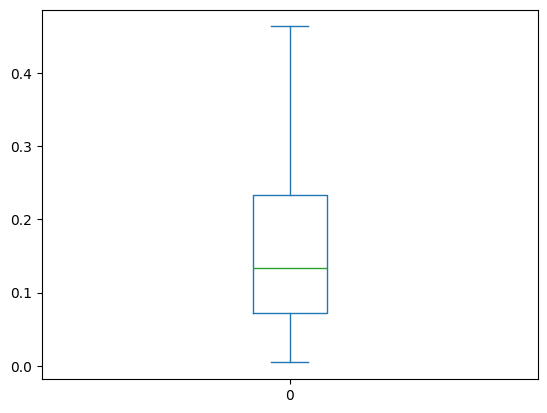

In [10]:
pd.DataFrame(test.sim_diffusion_matrix[array[:, 0], array[:, 1]+ test.len_A]).plot(kind = "box")

In [11]:
unused_anchors = dc.anchors[~np.isin(dc.anchors, test.known_anchors)[:,0]]

In [12]:
len(unused_anchors), len(test.known_anchors)

(134, 16)

In [13]:
pd.DataFrame(test.sim_diffusion_matrix[unused_anchors[:, 0], unused_anchors[0, 1] + test.len_A]).describe()

,0
count,134.000000
mean,0.622475
std,0.187545
min,0.319719
25%,0.455021
50%,0.607784
75%,0.844901
max,0.864809


<Axes: >

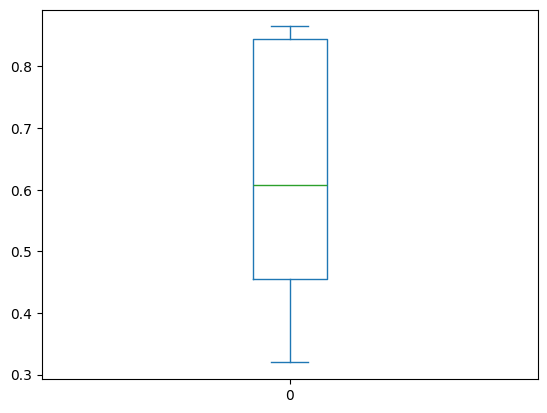

In [14]:
pd.DataFrame(test.sim_diffusion_matrix[unused_anchors[:, 0], unused_anchors[0, 1] + test.len_A]).plot(kind = "box")

# Testing the validification accuracy of this on repeat

In [15]:
def optimize_by_pred_anchors(self, epochs = 3, **find_possible_anchors_kwargs):
    """Finds potential anchors after alignment, and then recalculates the entire alignment with the new anchor points for each epoch. 
    
    Parameters:
    :anchor_limit: should be an integer. If fixed, it will determine the max anchors the algorithm will find.
    :epochs: the number of iterations the cycle will go through. 
    """
    
    #Rebuild Class for each epoch
    for epoch in range(0, epochs):

        #Find predicted anchors
        predicted_anchors, array = _find_possible_anchors(self, **find_possible_anchors_kwargs)

        if len(predicted_anchors) < 1:
            print("No predicted anchors foud. Exiting process")

            #Add in the known anchors and reset the known_anchors
            if "hold_out_anchors" in find_possible_anchors_kwargs.keys():
                self.known_anchors = np.concatenate((self.known_anchors, find_possible_anchors_kwargs["hold_out_anchors"]), axis = 0)
        else:

            #On the final epoch, we can evaluate with the hold_out_anchors and then assign them as anchors. 
            if epoch == epochs - 1 and "hold_out_anchors" in find_possible_anchors_kwargs.keys():
                predicted_anchors = np.concatenate((find_possible_anchors_kwargs["hold_out_anchors"], predicted_anchors), axis = 0)

            #Add in the known anchors and reset the known_anchors
            self.known_anchors = np.concatenate((self.known_anchors, predicted_anchors), axis = 0)

        #Reconnect the graphs based on the new anchors
        self.graphAB = self.merge_graphs()
        
        #Get Similarity matrix and distance matricies
        self.similarity_matrix = self.get_pure_matricies(self.graphAB)

        #Get Diffusion Matrix
        self.sim_diffusion_matrix, self.projectionAB, self.projectionBA = self.get_diffusion(self.similarity_matrix, self.t, link = self.link)

        if len(predicted_anchors) < 1:
            #Process didn't finish
            return False
        
    #Process Finished
    return True

In [16]:
test.known_anchors, len(test.known_anchors)

(array([[ 28,  28],
        [  6,   6],
        [ 70,  70],
        [ 62,  62],
        [ 57,  57],
        [ 35,  35],
        [ 26,  26],
        [139, 139],
        [ 22,  22],
        [108, 108],
        [  8,   8],
        [  7,   7],
        [ 23,  23],
        [ 55,  55],
        [ 59,  59],
        [129, 129]]),
 16)

In [17]:
optimize_by_pred_anchors(test, epochs = 5, anchor_limit = 1, hold_out_anchors = dummy_array)

Threshold: 0.19338137065424937


Threshold: 0.1931011244912056


Threshold: 0.20192182653054241


Threshold: 0.20150262963184615


Threshold: 0.2007023282042187




True

In [18]:
test.known_anchors, len(test.known_anchors)

(array([[ 28,  28],
        [  6,   6],
        [ 70,  70],
        [ 62,  62],
        [ 57,  57],
        [ 35,  35],
        [ 26,  26],
        [139, 139],
        [ 22,  22],
        [108, 108],
        [  8,   8],
        [  7,   7],
        [ 23,  23],
        [ 55,  55],
        [ 59,  59],
        [129, 129],
        [ 24,  40],
        [ 11,  18],
        [ 49,  17],
        [ 20,  43],
        [ 10,  10],
        [ 39,  39],
        [ 30,  30],
        [ 31,  31],
        [ 60,  60],
        [ 90,  90],
        [100, 100],
        [112, 112],
        [142, 142],
        [144, 144],
        [129, 129],
        [ 43,  44]]),
 32)

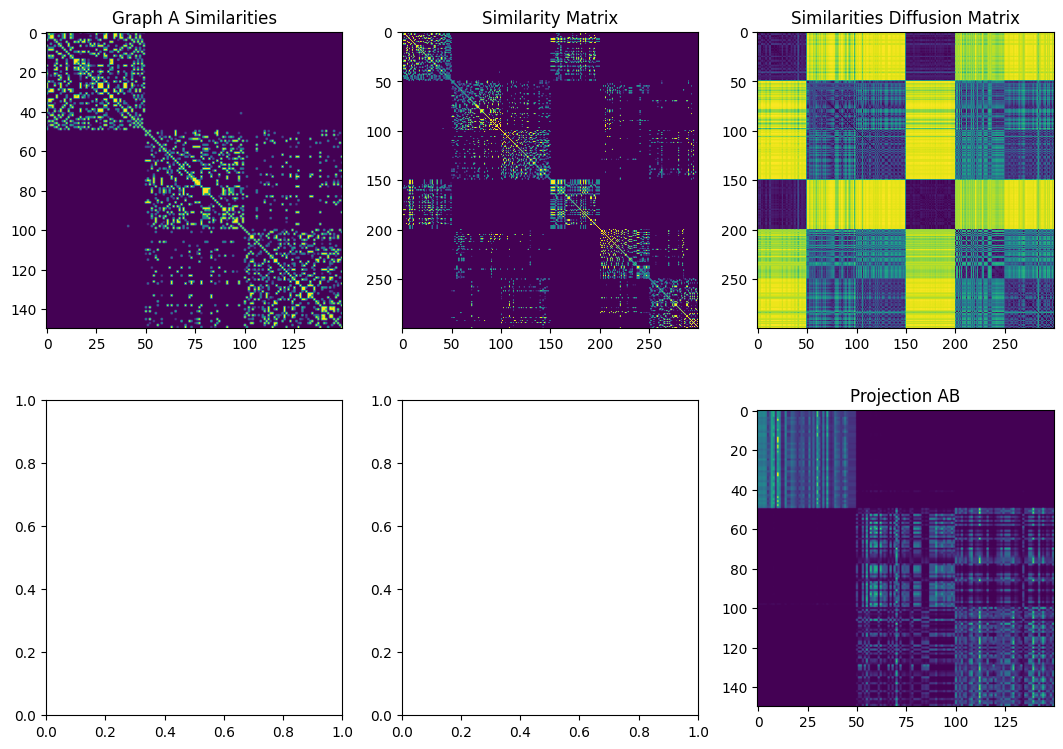

In [19]:
test.plot_graphs()

Model Stress: 13.697603601284634
Cross Embedding: 0.76
FOSCTTM: 0.17724444444444445


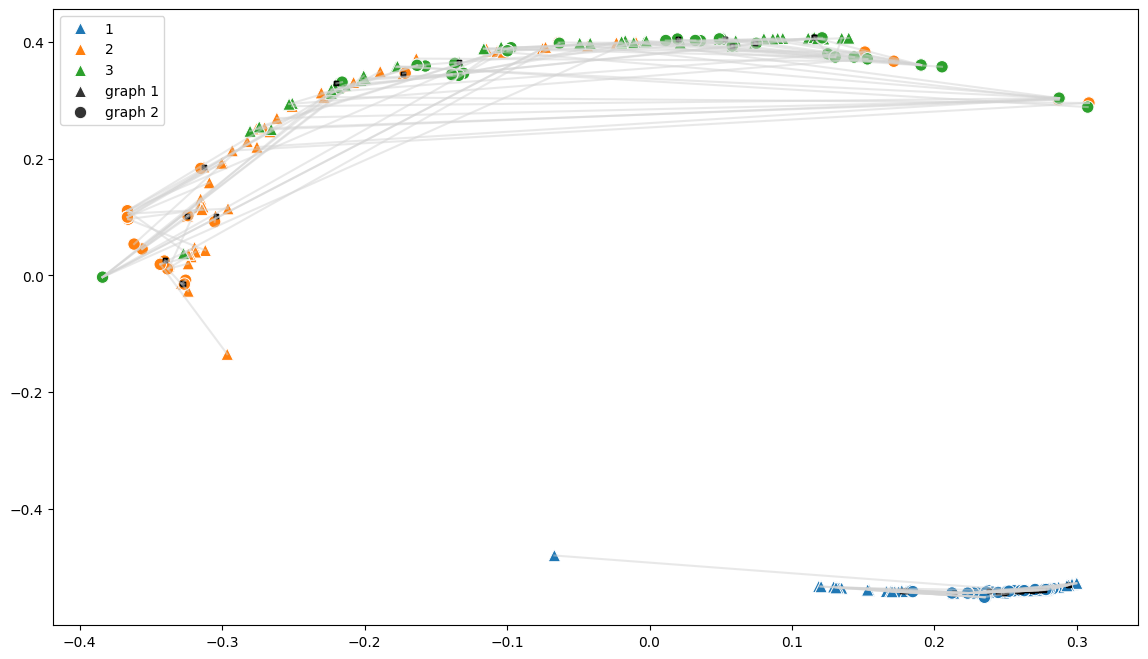

In [20]:
test.plot_emb(labels = dc.labels_doubled, block = test.sim_diffusion_matrix)

# Random Trials

In [21]:
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:16], t = -1, knn = 7, link = "None", verbose = 2)

In [22]:
test.known_anchors

array([[ 28,  28],
       [  6,   6],
       [ 70,  70],
       [ 62,  62],
       [ 57,  57],
       [ 35,  35],
       [ 26,  26],
       [139, 139],
       [ 22,  22],
       [108, 108],
       [  8,   8],
       [  7,   7],
       [ 23,  23],
       [ 55,  55],
       [ 59,  59],
       [129, 129]])

In [23]:
test.known_anchors[np.argmin(test.sim_diffusion_matrix[test.known_anchors[:, 0], test.known_anchors[:, 1] + 150])]

array([55, 55])

In [24]:
anc = 55
anc2 = anc +150

In [25]:
test.sim_diffusion_matrix[anc, anc2]

0.0

In [26]:
np.argmin(test.sim_diffusion_matrix[anc, 150:])

55

In [27]:
test.sim_diffusion_matrix[anc, anc2] = 1

In [28]:
next_anc = np.argmin(test.sim_diffusion_matrix[anc, 150:])
next_anc

53

In [29]:
test.sim_diffusion_matrix[anc, next_anc + 150] = 1
np.argmin(test.sim_diffusion_matrix[:150, next_anc + 150])

84

In [30]:
test.sim_diffusion_matrix[next_anc, next_anc + 150], np.min(test.sim_diffusion_matrix[:150, next_anc + 150])

(0.22482215995805485, 0.16486740239838782)

# Visualizing the problem
"""A lot of the points are closest to a certain point --- and that one that is closest to that point is the anchor""" --> Not True 

In [59]:
test = DIG_V2.DIG(dc.split_A, dc.split_B, dc.anchors[:15], t = -1, knn = 2, link = "None", verbose = 2)

In [60]:
test.known_anchors

array([[ 28,  28],
       [  6,   6],
       [ 70,  70],
       [ 62,  62],
       [ 57,  57],
       [ 35,  35],
       [ 26,  26],
       [139, 139],
       [ 22,  22],
       [108, 108],
       [  8,   8],
       [  7,   7],
       [ 23,  23],
       [ 55,  55],
       [ 59,  59]])

In [61]:
array = test.sim_diffusion_matrix[:test.len_A, test.len_A:]

#Get rid of the known anchors
#array[test.known_anchors[:, 0], :] = np.inf
array[:, test.known_anchors[:, 1]] = np.inf

#Loop through each row
for row in range(0, test.len_A):
    #Get the anchor value
    anc_value = array[row, row]

    #Get the min position value
    min_pos = np.argmin(array[row, :])

    #Get the min value
    min_value = np.min(array[row, :])

    print(f"Row {row}: The mininum position is {min_pos} with a value of {min_value}. The anchor value is {anc_value}\n")

Row 0: The mininum position is 5 with a value of 0.15426367765464152. The anchor value is 0.16724814194638474

Row 1: The mininum position is 69 with a value of 0.4909200468535936. The anchor value is 0.5171970556439283

Row 2: The mininum position is 19 with a value of 0.221826133433523. The anchor value is 0.3703318594736505

Row 3: The mininum position is 19 with a value of 0.2389008272471241. The anchor value is 0.3870264320587645

Row 4: The mininum position is 0 with a value of 0.17271685215830315. The anchor value is 0.17907323517202817

Row 5: The mininum position is 69 with a value of 0.45136961971077344. The anchor value is 0.7763807144714718

Row 6: The mininum position is 17 with a value of 0.04960515689204866. The anchor value is inf

Row 7: The mininum position is 0 with a value of 0.08426233789176307. The anchor value is inf

Row 8: The mininum position is 20 with a value of 0.05165170045593506. The anchor value is inf

Row 9: The mininum position is 2 with a value of 0.